✅ 폰트 설정: NanumGothic (Linux/Docker)
조정된 데이터 비율 (퇴사자:재직자) = 1 : 6
예상 Base Value: 14.3%


/usr/local/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [07:33:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- [분석 대상: 퇴사 위험 1위] ---
사번: E00412
예측된 퇴사 위험도: 94.7%
Base Value (평균 퇴사율): 24.12%


/usr/local/lib/python3.12/site-packages/shap/plots/_waterfall.py:279: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  text_bbox = txt_obj.get_window_extent(renderer=renderer)
/usr/local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


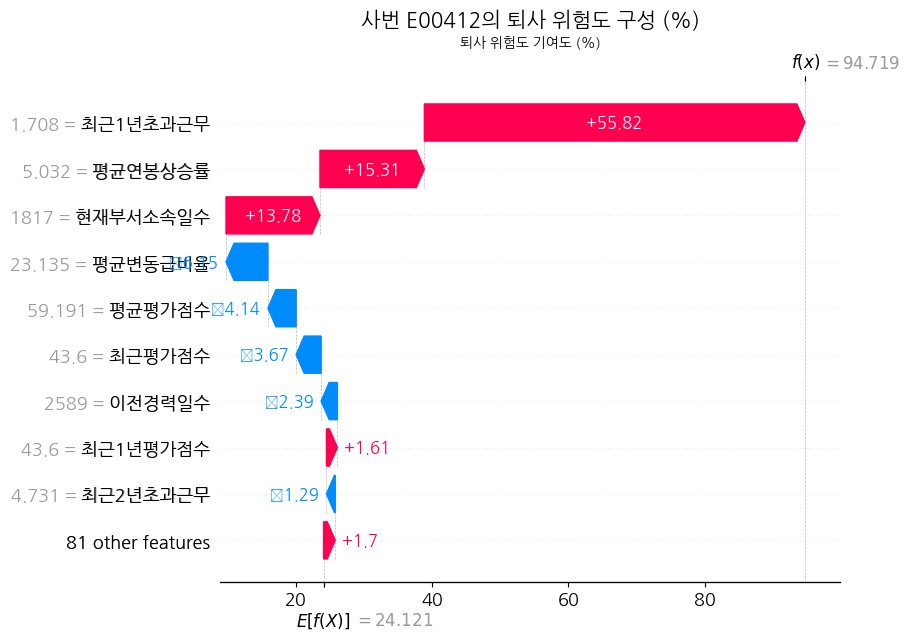

In [25]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

from services.tables.create_ml_table import master_df_encoded

# --- 1. 한글 폰트 설정 (Docker 환경 대응) ---
def set_korean_font():
    # 사용 가능한 폰트 리스트 확인
    font_names = [f.name for f in fm.fontManager.ttflist]
    
    # 1순위: 나눔고딕 (Linux/Docker 표준), 2순위: 맑은 고딕 (Windows), 3순위: 애플고딕 (Mac)
    if 'NanumGothic' in font_names:
        plt.rcParams['font.family'] = 'NanumGothic'
        print("✅ 폰트 설정: NanumGothic (Linux/Docker)")
    elif 'Malgun Gothic' in font_names:
        plt.rcParams['font.family'] = 'Malgun Gothic'
        print("✅ 폰트 설정: Malgun Gothic (Windows)")
    elif 'AppleGothic' in font_names:
        plt.rcParams['font.family'] = 'AppleGothic'
        print("✅ 폰트 설정: AppleGothic (Mac)")
    else:
        # 폰트가 없을 경우 경고 메시지 출력 및 영어 설정 (깨짐 방지)
        print("⚠️ 한글 폰트를 찾을 수 없습니다. Docker에서 'apt-get install -y fonts-nanum'을 실행해주세요.")
        print("   (임시로 영문 폰트를 사용합니다.)")
        plt.rcParams['font.family'] = 'DejaVu Sans' # 기본 영문 폰트

set_korean_font()
plt.rcParams['axes.unicode_minus'] = False

# --- 2. 데이터 준비 ---

# 데이터 타입 정리
for col in master_df_encoded.columns:
    if master_df_encoded[col].dtype == 'object' and col not in ['사번', '재직여부', '퇴사자여부']:
        master_df_encoded[col] = pd.to_numeric(master_df_encoded[col], errors='coerce')
master_df_encoded.fillna(master_df_encoded.median(numeric_only=True), inplace=True)

# --------------------------------------------------------------------------------
# [Step 1] 데이터 비율 9:1 만들기 (Base Value를 낮추기 위함)
# --------------------------------------------------------------------------------
df_leavers = master_df_encoded[master_df_encoded['퇴사자여부'] == 1]
df_active = master_df_encoded[master_df_encoded['퇴사자여부'] == 0]

n_leavers = len(df_leavers)
n_required_active = n_leavers * 6 # 1:6 비율

# 재직자 뻥튀기 (Oversampling)
df_active_oversampled = df_active.sample(n=n_required_active, replace=True, random_state=42)

# 학습 데이터 생성
balanced_df = pd.concat([df_leavers, df_active_oversampled], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"조정된 데이터 비율 (퇴사자:재직자) = 1 : {len(df_active_oversampled)/len(df_leavers):.0f}")
print(f"예상 Base Value: {balanced_df['퇴사자여부'].mean()*100:.1f}%")

# --------------------------------------------------------------------------------

drop_cols = ['사번', '재직여부', '퇴사자여부']
feature_cols = [col for col in balanced_df.columns if col not in drop_cols]

X_train = balanced_df[feature_cols].astype(float)
y_train = balanced_df['퇴사자여부'].astype(float)

# --------------------------------------------------------------------------------
# [Step 2] 핵심: scale_pos_weight 설정 (확률을 뻥튀기하기 위함)
# --------------------------------------------------------------------------------
# 퇴사자(1)에 대한 가중치를 높여서, 조금만 징후가 보여도 확률을 높게 예측하게 함
# 보통 '음성 클래스 수 / 양성 클래스 수'로 설정하지만, '보여주기'를 위해 값을 더 높여도 됨
weight_ratio = 70  # (6:1 불균형을 상쇄할 만큼의 힘)

model = xgb.XGBClassifier(
    n_estimators=weight_ratio, 
    max_depth=2,             
    learning_rate=0.1, 
    scale_pos_weight=weight_ratio,  # <--- [핵심] 이 값이 높을수록 퇴사 확률이 높게 나옴
    random_state=42, 
    min_child_weight=10, 
    use_label_encoder=False, 
    eval_metric='logloss'
)
model.fit(X_train, y_train)
# --------------------------------------------------------------------------------

# --- 4. 고위험군(1위) 선정 (원본 데이터에서 탐색) ---
active_employees_original = master_df_encoded[master_df_encoded['재직여부'] == 'Y'].copy()

if active_employees_original.empty:
    print("분석할 재직자가 없습니다.")
else:
    X_active_real = active_employees_original[feature_cols].astype(float)
    probs = model.predict_proba(X_active_real)[:, 1]
    
    active_employees_original['PREDICTED_RISK'] = probs
    sorted_risk_df = active_employees_original.sort_values(by='PREDICTED_RISK', ascending=False)
    
    top_risk_emp = sorted_risk_df.iloc[0]
    top_emp_id = top_risk_emp['사번']
    top_risk_score = top_risk_emp['PREDICTED_RISK']

    print(f"\n--- [분석 대상: 퇴사 위험 1위] ---")
    print(f"사번: {top_emp_id}")
    print(f"예측된 퇴사 위험도: {top_risk_score*100:.1f}%")

    # --- 5. SHAP 분석 ---
    target_X_numpy = X_active_real.loc[[top_risk_emp.name]].values
    
    # 배경 데이터: 학습 데이터에서 샘플링 (여기 비율도 9:1이므로 Base Value는 낮게 유지됨)
    background_data = shap.sample(X_train, 100)

    explainer = shap.TreeExplainer(
        model, 
        data=background_data, 
        feature_perturbation="interventional",
        model_output="probability"
    )
    
    shap_values = explainer(target_X_numpy)
    
    # % 변환
    shap_values.values = shap_values.values * 100
    shap_values.base_values = shap_values.base_values * 100
    
    print(f"Base Value (평균 퇴사율): {shap_values.base_values[0]:.2f}%")

    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(
        shap_values[0],
        max_display=10,
        show=False
    )
    plt.title(f"사번 {top_emp_id}의 퇴사 위험도 구성 (%)", fontsize=15)
    plt.xlabel("퇴사 위험도 기여도 (%)")
    plt.show()

In [26]:
sorted_risk_df['PREDICTED_RISK'].round(2)

411    0.95
966    0.80
111    0.79
583    0.79
699    0.70
       ... 
38     0.02
700    0.02
805    0.02
304    0.02
627    0.02
Name: PREDICTED_RISK, Length: 480, dtype: float32

In [27]:
sorted_risk_df['PREDICTED_RISK'].round(2).head(20)

411    0.95
966    0.80
111    0.79
583    0.79
699    0.70
366    0.69
620    0.68
518    0.68
766    0.66
408    0.63
296    0.62
113    0.59
271    0.57
789    0.55
581    0.50
633    0.49
635    0.48
134    0.46
817    0.44
970    0.41
Name: PREDICTED_RISK, dtype: float32